## Multi-modal RAG



## Packages

In addition to the below pip packages, you will also need `poppler` ([installation instructions](https://pdf2image.readthedocs.io/en/latest/installation.html)) and `tesseract` ([installation instructions](https://tesseract-ocr.github.io/tessdoc/Installation.html)) in your system.

In [ ]:
! pip install -U langchain openai langchain-chroma langchain-experimental # (newest versions required for multi-modal)

In [ ]:
! pip install "unstructured[all-docs]" pillow pydantic lxml pillow matplotlib chromadb tiktoken

## 데이터 로딩
### PDF의 표, 텍스트, 이미지 분할


In [69]:
from langchain_text_splitters import CharacterTextSplitter
from unstructured.partition.pdf import partition_pdf


# Extract elements from PDF
def extract_pdf_elements(path, fname):
    """
    Extract images, tables, and chunk text from a PDF file.
    path: File path, which is used to dump images (.jpg)
    fname: File name
    """
    return partition_pdf(
        filename=path + fname,
        extract_images_in_pdf=True,
        infer_table_structure=True,
        chunking_strategy="by_title",
        max_characters=4000,
        new_after_n_chars=3800,
        combine_text_under_n_chars=2000,
        image_output_dir_path=path,
        # image_output_dir_path=os.path.join(os.getcwd(),"figures"),
    )


# Categorize elements by type
def categorize_elements(raw_pdf_elements):
    """
    Categorize extracted elements from a PDF into tables and texts.
    raw_pdf_elements: List of unstructured.documents.elements
    """
    tables = []
    texts = []
    for element in raw_pdf_elements:
        if "unstructured.documents.elements.Table" in str(type(element)):
            tables.append(str(element))
        elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
            texts.append(str(element))
    return texts, tables


In [70]:
import os

# 현재 실행 중인 스크립트의 디렉토리 경로를 찾습니다.
# script_directory = os.path.dirname(os.path.abspath(__file__))

current_directory = os.getcwd()
fname = "20240806_market_145038000.pdf"
fpath = os.path.join(os.getcwd(),"cj/")

print("현재 스크립트의 위치:", current_directory)
print("pdf 위치:",fpath)

현재 스크립트의 위치: /Users/usermackbookpro/langchain-python/langchain-jupyter
pdf 위치: /Users/usermackbookpro/langchain-python/langchain-jupyter/cj/


### 요소 추출

`extract_pdf_elements(fpath, fname)`: PDF 파일의 경로와 이름을 받아서 PDF 요소를 추출합니다.

### 텍스트와 표 요소 분류

`categorize_elements(raw_pdf_elements)`: 추출된 요소를 텍스트와 표로 분류합니다.

### 선택사항: 텍스트의 특정 토큰 크기 강제 적용

`CharacterTextSplitter.from_tiktoken_encoder(...)`: 텍스트를 특정 크기로 분할하기 위해 텍스트 분할기를 초기화합니다.
- `chunk_size=3000`: 각 텍스트 청크의 최대 크기를 3000자로 설정합니다.
- `chunk_overlap=200`: 청크 간의 겹침을 200자로 설정합니다.
- `joined_texts = " ".join(texts)`: 모든 텍스트를 하나의 문자열로 결합합니다.
- `texts_6k_token = text_splitter.split_text(joined_texts)`: 결합된 텍스트를 설정한 크기와 겹침으로 분할합니다.

In [71]:
# File path
# fpath = "/Users/rlm/Desktop/cj/"
# fname = "cj.pdf"
# fpath = os.join(os.getcwd(),"cj",fname)

# Get elements
raw_pdf_elements = extract_pdf_elements(fpath, fname)

# Get text, tables
texts, tables = categorize_elements(raw_pdf_elements)

# Optional: Enforce a specific token size for texts
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=6000, chunk_overlap=200
)
joined_texts = " ".join(texts)
texts_4k_token = text_splitter.split_text(joined_texts)

In [72]:
texts_4k_token

["2024.08.06\n\n간판과  본질  \n\n     \n\nKOSPI는 낙폭 과대, 미국 기술주는 아직 주의\n\nEquity Strategy\n\n[시황/전략] 이웅찬 (2122-9188) wlee@imfnsec.com [퀀트/RA] 신희철 (2122-9187) shc4235@ imfnsec.com\n\n미 기술주는 비쌌고 경기 하강 우려는 과소평가되었다고 판단하지만, KOSPI 지수의 일간 사상 최대 폭락은 과도한 부분이 있었다. 단기 반등 및 기간조정을 지난 다음 10월 이후의 변곡점을 준비하자.\n\n역시 물가'만' 잡힌 것이 아니었네\n\n리세션 우려가 갑작스럽다는 의견도 있으나 미국 경제의 거의 모든 부문에서 고금리의 영향에 따른 경기 하강의 징후가 나타나고 있었으며, AI 투자지출이 미국 경제의 호황을 이어갈 것이라는 낙관론이 과도했다고 판단한다. 리세션의 여부보다는 경제는 하강하고 있는데 연준은 빠르게 완화하기 어렵다는 사실이 중요하다. 연준이 늦은 것이 아니라 나스닥 기술주가 비쌌다고 말하고 싶다.\n\nCapex냐 EPS냐, 외통수에 걸린 나스닥\n\n빅테크 기업은 AI 경쟁을 계속하겠다면 소프트웨어 회사의 주가가, 투자를 줄이고 이익을 지키겠다면 반도체 회사의 조정으로 귀결될 수 있다. 시장은 리세션을 우려하며 급락했으나 리세션이 아니더라도 경기는 하강하고 있는데 선행 EPS는 견조했고 밸류에이션은 비싸서 주식에 우호적인 환경이 아니었다. 그 외에도 2분기 중에는 기술주에 대한 많은 고점 시그널들이 나타났다. 엔캐리 트레이딩의 언와인딩은 조정 트리거가 되었을 수는 있겠으나 본질은 기술주가 비쌌다는데 있다. 미 증시는 2013년 이후 장기 강세장을 마무리하는지 여부가 고민된다.\n\nKOSPI는 과매도, 전망보다 대응의 영역. 10월 이후 변곡점을 기대\n\n나스닥, S&P500 지수는 추세상승선을 이탈했으나 아직 이격이 커 단기 반등을 전망하기 어렵다. 9월 FOMC에서 연준의 전격 50bp 금리 인하 등이 진행된다면 증시 반등이 

## 멀티 벡터 리트리버

[멀티 벡터 리트리버](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary)를 사용하여 이미지(및/또는 텍스트, 표) 요약을 인덱싱하고, 원본 이미지(원본 텍스트 또는 표와 함께)를 검색합니다.

### 텍스트 및 표 요약

GPT-4 or llama3.1를 사용하여 표 및 선택적으로 텍스트 요약을 생성할 것입니다.

큰 청크 크기(예: 위에서 설정한 4k 토큰 청크)를 사용하는 경우 텍스트 요약을 권장합니다.

요약은 원본 표 및/또는 원본 텍스트 청크를 검색하는 데 사용됩니다.

In [73]:
import os
from dotenv import load_dotenv
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("openai api 키가 없습니다. 한번더 확인 부탁드립니다.")


In [74]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_ollama.llms import OllamaLLM

# Generate summaries of text elements
def generate_text_summaries(texts, tables, summarize_texts=False):
    """
    텍스트 요소 요약 생성
    texts: str 리스트
    tables: str 리스트
    summarize_texts: 텍스트 요약 여부를 나타내는 부울 값
    """

    # Prompt
    # prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    # These summaries will be embedded and used to retrieve the raw text or table elements. \
    # Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """

    prompt_text_kor = """당신은 표와 텍스트를 요약하여 검색에 활용할 수 있도록 돕는 도우미입니다. \n 
    이 요약본들은 임베딩되어 원본 텍스트나 표 요소를 검색하는 데 사용될 것입니다. \n 
    주어진 표나 텍스트의 내용을 검색에 최적화된 간결한 요약으로 작성해 주세요. 요약할 표 또는 텍스트: {element}"""
    
    prompt = ChatPromptTemplate.from_template(prompt_text_kor)

    # Text summary chain
    # model = ChatOpenAI(temperature=0, model="gpt-4o-mini")
    llamaModel = OllamaLLM(model="llama3.1:8b")
    summarize_chain = {"element": lambda x: x} | prompt | llamaModel | StrOutputParser()

    # Initialize empty summaries
    text_summaries = []
    table_summaries = []

    # Apply to text if texts are provided and summarization is requested
    if texts and summarize_texts:
        text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
    elif texts:
        text_summaries = texts

    # Apply to tables if tables are provided
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

    return text_summaries, table_summaries


# Get text, table summaries
text_summaries, table_summaries = generate_text_summaries(
    texts_4k_token, tables, summarize_texts=True
)

In [75]:
print(text_summaries)


['미국 경기 하강 가능성을 반영하지 못했다고 판단됩니다. 고금리의 영향에 따른 경기 하강이 나타났음에도 불구하고, AI 투자가 미국 경제의 호황을 이어갈 것이라는 낙관론이 과도했다고 생각합니다.', '이 글은 빅테크 기업의 AI Capex와 EPS 사이의 고민을 다룬 것 같습니다. Microsoft, Meta 등 주요 빅테크 소프트웨어 기업들이 실적 발표에서 AI Capex를 이어가겠다고 발표했으며, 반도체 주식은 안도하며 단기 반등을 만들어 냈습니다. 그러나 Capex 유지 가능성에 대한 의문은 계속되고 있으며, Alphabet은 AI로 인한 수익화는 아직 멀어보이고 투자는 부담이라 언급했습니다.\n\nMicrosoft의 이번 분기에 220억 달러의 순이익을 냈는데, Capex 지출로 순이익 전부에 육박하는 190억 달러를 지출했다고 합니다. 회사에서는 AI 경쟁을 위해 투자를 이어가고 있으나 Capex 규모는 상황이 악화되면 언제나 축소할 수 있다며 투자자들을 달랬습니다.\n\nCapex 지출 중 절반은 토지, 건물 등 장기간에 걸쳐 감가상각 비용을 인식하지만, 나머지 절반 가량은 GPU, CPU 등의 설비로 상대적으로 짧은 감가상각 연한을 가진다고 합니다. 이에 따르면 24년에 집행한 Capex로 인한 25년도 감가상각비 증가 규모는 60억 달러 내외로 추정됩니다.\n\nMicrosoft의 내년 매출 성장률 컨센서스는 약 +10%, 이익 성장률은 약 +15% 정도입니다. 경제에 큰 문제가 없다면 클라우드 매출 증가 등이 감가상각 비용을 상쇄하고 성장을 이끌겠으나, 경기 하강이 예상보다 빨라진다면 매출 성장이 둔화되며 이익 전망치를 달성하기 어렵게 될 것입니다.\n\n반도체 주식의 안동은 단기 반등을 만들 수 있지만, 경기 하강 가능성을 고려할 때 여전히 위험 요소가 있습니다. Alphabet에서 AI로 인한 수익화는 아직 멀어보이고 투자는 부담이라 언급한 바 있다면서, AI 투자의 장래에 대한 의문이 제기됩니다.\n\n이러한 고민은 미국 증시의 내년 이

In [76]:
print(table_summaries)

[]


### GPT-4 Vision 및 LLaVA를 이용한 이미지 요약

이 스크립트는 이미지를 base64 형식으로 인코딩하고 GPT-4 Vision 및 LLaVA 모델을 사용하여 간결한 요약을 생성합니다.

#### 모듈 및 함수

1. **임포트**
    - `base64`, `os`, `requests`, `json`: 이미지를 인코딩하고 파일 작업을 처리하며 HTTP 요청을 수행하고 JSON 데이터를 처리합니다.
    - `HumanMessage` from `langchain_core.messages`: 메시지 처리를 위해 사용됩니다.

2. **함수 정의**
    - `encode_image(image_path)`: 이미지 파일을 base64 문자열로 인코딩합니다.
    - `image_summarize(img_base64, prompt)`: GPT-4 Vision을 사용하여 이미지 요약을 생성합니다.
    - `image_summarize_llava(img_base64, prompt)`: LLaVA를 사용하여 이미지 요약을 생성합니다.

3. **이미지 요약 프로세스**
    - `generate_img_summaries(path)`: 
        - 지정된 디렉토리에서 이미지를 base64 문자열로 인코딩합니다.
        - LLaVA를 사용하여 이미지 요약을 생성합니다.
        - base64로 인코딩된 이미지와 해당 요약의 리스트를 반환합니다.
        - 한국어 프롬프트(`prompt_kor`)와 영어 프롬프트(`prompt`)를 사용하여 요약을 생성합니다.

4. **실행**
    - 현재 작업 디렉토리를 가져옵니다.
    - 'figures' 디렉토리의 경로를 설정합니다.
    - 디렉토리 내 이미지에 대한 요약을 생성합니다.

#### 코드 실행

1. `encode_image`를 사용하여 이미지 파일을 base64 형식으로 인코딩합니다.
2. `image_summarize` 및 `image_summarize_llava`를 사용하여 요약을 생성합니다.
3. base64로 인코딩된 이미지와 해당 요약을 저장합니다.
4. 'figures' 디렉토리의 경로를 출력하고 해당 디렉토리의 이미지에 대한 요약을 생성합니다.

In [77]:
import base64
import os
import requests
import json
from langchain_core.messages import HumanMessage


def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
    """Make image summary"""
    chat = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=1024)
    # chat = OllamaLLM(model="llava:7b")

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    print(msg)
    return msg.content
    
def image_summarize_llava(img_base64, prompt):
    """Make image summary using LLaVA"""
    payload = {
        "model": "llava:7b",
        "prompt": prompt,
        "images": [img_base64]
    }

    response = requests.post(
        "http://localhost:11434/api/generate", json=payload)

    # print("Response: ", response)
    print("Status Code: ", response.status_code)
    # print("Headers: ", response.headers)
    # print("Content: ", response.content)

    if response.status_code == 200:
        try:
            # 응답을 줄 단위로 처리
            full_response = ""
            for line in response.iter_lines():
                if line:
                    json_line = json.loads(line)
                    if 'response' in json_line:
                        full_response += json_line['response']
            print(full_response)
            return full_response
        except json.JSONDecodeError as e:
            return f"JSON 파싱 오류: {str(e)}\n응답 내용: {response.text}"
    else:
        return f"Error: {response.status_code}, {response.text}"


def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt_kor 한국어
    prompt_kor = """You are an assistant tasked with summarizing images for retrieval. 
    These summaries will be embedded and used to retrieve the raw image. Provide a concise summary of the image that is well optimized for retrieval. 
    The summary should be written in Korean (Hangul)."""

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. 
    These summaries will be embedded and used to retrieve the raw image. Provide a concise summary of the image that is well optimized for retrieval. """


    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith((".jpg",".png",".jpeg")):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize_llava(base64_image, prompt_kor))

    return img_base64_list, image_summaries

print(fpath)

# 현재 작업 디렉토리 경로를 찾습니다.
current_directory = os.getcwd()

# 'langchain-jupyter' 디렉토리를 기준으로 'figures' 폴더 경로를 설정합니다.
# os.path.dirname를 사용하여 부모 디렉토리를 찾습니다.
figures_directory = os.path.join(current_directory, "figures")

print(figures_directory)



# Image summaries
# img_base64_list, image_summaries = generate_img_summaries(fpath)
img_base64_list, image_summaries = generate_img_summaries(figures_directory)

/Users/usermackbookpro/langchain-python/langchain-jupyter/cj/
/Users/usermackbookpro/langchain-python/langchain-jupyter/figures
Status Code:  200
 한글로 요약하기는 어렵습니다. 이미지에 있는 한글과 같은 내용을 텍스트로 추가할 수 있으면, 더 자세한 설명이 가능합니다. 
Status Code:  200
 이미지는 "M1M" 라는 글자가 있는 로고입니다. 로고에서 "M1M"은 파란색으로 작게 표시되며, 위쪽에서 큰 삼각형과 같은 구문으로 굴쳐져 있는 문자입니다. 이미지의 배경 색상은 컬러 그림자로 표시되어 있습니다. 
Status Code:  200
 한글은 이미지에 포함된 내용을 간결하고 검색에 최적화된 형태로 작성합니다.

이 이미지는 대한민국과 베르그 간의 산업 통제 위원회(WTO)의 통합 산업 내역을 표시하고 있습니다. 한글은 이러한 정보를 간결하게 요약하여 검색에 최적화된 형태로 작성합니다.

이미지는 "Bloomberg"라는 기관의 데이터를 기반으로 산업 내역을 표시합니다. 이러한 통합 산업 내역은 2023년에 대한민국과 베르그 간의 산업 생산량을 요약한 것으로 보입니다.

또한, 이미지에는 "전력"이라는 서브제기(Sub-chart)가 포함되어 있습니다. 이 서브je기는 전력 생산량을 나타내고 있습니다.

이 정보를 간결하게 요약한 후, 이미지에 대해 "국제적인 산업 통제 위원회(WTO)"라는 제목으로 설명합니다.

이와 같은 최적화된 한글 요약은 검색 엔진의 자동 정보 추출기(AutoML)에서 일어나며, 인식하는 시스템에서 재사용되어 저장될 수 있습니다. 이러한 최적화된 요약은 검색 결과에 자동으로 추가될 수 있습니다. 
Status Code:  200
 The image appears to be a screenshot of a financial chart, showing the performance or movement of a st

In [78]:
# len(img_base64_list)
len(image_summaries)
image_summaries[1]

' 이미지는 "M1M" 라는 글자가 있는 로고입니다. 로고에서 "M1M"은 파란색으로 작게 표시되며, 위쪽에서 큰 삼각형과 같은 구문으로 굴쳐져 있는 문자입니다. 이미지의 배경 색상은 컬러 그림자로 표시되어 있습니다. '

### 다중 벡터 검색기 생성 및 사용

이 스크립트는 다중 벡터 검색기를 생성하여 텍스트, 표, 이미지 요약을 색인화하고 원본 이미지를 반환합니다.

#### 모듈 및 함수

1. **임포트**
    - `uuid`를 사용하여 고유 식별자를 생성합니다.
    - `MultiVectorRetriever`, `InMemoryStore`, `Chroma`, `Document`, `OpenAIEmbeddings`, `OpenCLIPEmbeddings`를 사용하여 검색기 및 벡터 저장소를 설정합니다.

2. **함수 정의**
    - `create_multi_vector_retriever(vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images)`: 
        - 요약을 색인화하고 원본 이미지를 반환하는 검색기를 생성합니다.
        - InMemoryStore를 초기화하고, MultiVectorRetriever를 생성합니다.
        - 도큐먼트를 벡터 저장소와 도큐먼트 저장소에 추가하는 헬퍼 함수를 정의합니다.
        - 텍스트, 표, 이미지 요약을 추가합니다.

3. **코드 실행**

1. **임포트 및 초기 설정**
    - 필요한 모듈 및 함수를 임포트합니다.
    - `OpenCLIPEmbeddings`를 사용하여 임베딩을 초기화합니다.
    - `Chroma` 벡터 저장소를 설정합니다.

2. **검색기 생성**
    - `create_multi_vector_retriever` 함수를 호출하여 다중 벡터 검색기를 생성합니다.
    - 텍스트, 표, 이미지 요약을 추가합니다.

In [79]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain_experimental.open_clip import OpenCLIPEmbeddings


def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    # Check that table_summaries is not empty before adding
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    # Check that image_summaries is not empty before adding
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever
    
# embedding = OpenCLIPEmbeddings(model_name="ViT-L-14", checkpoint="openai")
embedding = OpenCLIPEmbeddings()

# The vectorstore to use to index the summaries
vectorstore = Chroma(
    # collection_name="mm_rag_cj_blog", embedding_function=OpenAIEmbeddings()
    collection_name="mm_rag_finace", embedding_function=embedding
)

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
)

In [81]:
img_base64_list[0]

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABoAfcDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD2qiiuP+JPi688F+Fl1Wyt4J5TcpDsnztwQxzwR6UjA7CivnP/AIaF8Rf9AnS/yk/+Ko/4aF8Rf9AnS/yk/wDiqCuRn0ZRXzn/AMNC+Iv+gTpf5Sf/ABVH/DQviL/oE6X+Un/xVAcjPoyivPfhZ4+1Dx3banLf2trbm0eNUEA

### 다중 모달 RAG 체인 생성 및 사용

이 스크립트는 다중 모달 RAG(Retrieval-Augmented Generation) 체인을 생성하여 텍스트, 표, 이미지 데이터를 처리하고, 한국어로 투자 조언을 제공합니다.

#### 모듈 및 함수

1. **임포트**
    - `io`, `re`, `IPython.display`, `langchain_core.runnables`, `langchain.prompts`, `PIL.Image`: 다양한 모듈을 사용하여 이미지 처리, 데이터 처리, 디스플레이, 체인 생성 등을 수행합니다.

2. **함수 정의**
    - `plt_img_base64(img_base64)`: Base64 인코딩된 문자열을 이미지로 표시합니다.
    - `looks_like_base64(sb)`: 문자열이 Base64 형식인지 확인합니다.
    - `is_image_data(b64data)`: Base64 데이터가 이미지인지 확인합니다.
    - `resize_base64_image(base64_string, size=(128, 128))`: Base64 형식의 이미지를 리사이즈합니다.
    - `split_image_text_types(docs)`: Base64로 인코딩된 이미지와 텍스트를 분리합니다.
    - `img_prompt_func(data_dict)`: 주어진 데이터 딕셔너리로부터 메시지를 생성합니다.
    - `multi_modal_rag_chain(retriever)`: 다중 모달 RAG 체인을 생성합니다.
    - `korean_convert_rag()`: 영어 텍스트를 한국어로 변환하는 RAG 체인을 생성합니다.

3. **코드 실행**

1. **임포트 및 초기 설정**
    - 필요한 모듈 및 함수를 임포트합니다.

2. **이미지 처리 및 변환**
    - Base64 인코딩된 이미지를 처리하고 표시합니다.
    - 문자열이 Base64 형식인지, Base64 데이터가 이미지인지 확인합니다.
    - 이미지를 리사이즈합니다.
    - Base64로 인코딩된 이미지와 텍스트를 분리합니다.

3. **메시지 생성**
    - 주어진 데이터 딕셔너리로부터 메시지를 생성합니다.
    - 투자 분석을 위한 프롬프트 메시지를 구성합니다.

4. **RAG 체인 생성**
    - 다중 모달 RAG 체인을 생성합니다.
    - 영어 텍스트를 한국어로 변환하는 RAG 체인을 생성합니다.
    - 다중 모달 RAG 체인과 한국어 변환 RAG 체인을 결합합니다.

In [82]:
import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain.prompts import ChatPromptTemplate
from PIL import Image


def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are financial analyst tasking with providing investment advice.\n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to provide investment advice related to the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}\n\n"
            "Please provide the final answer in Korean(hangul)."
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)
    llava_model = OllamaLLM(model="llava:7b")
    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | llava_model # model
        | StrOutputParser()
    )

    return chain


def korean_convert_rag():
    """
    RAG chain for converting English text to Korean
    """
    # or gpt-4 oepn-ai 모델 선택부분은 공식 홈페이지에서 확인 가능합니다. 현재는 gpt-3.5-turbo 모델을 사용하겠습니다.
    # model = ChatOpenAI(model="gpt-3.5-turbo",temperature=0)
    llamaModel = OllamaLLM(model="llama3.1:8b")

    # Prompt template
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful assistant that translates English to Korean."),
        ("human", "Translate the following English text to Korean: {english_text}")
    ])

    # RAG pipeline
    chain = (
        {"english_text": RunnablePassthrough()}
        | prompt
        | llamaModel #model
        | StrOutputParser()
    )

    return chain

    

# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

#혹시나 답변이 영어로 나온다면 korean_convert_rag를 chain을 생성하여서 rag 진행
korean_convert_rag = korean_convert_rag()
final_multimodal_rag = chain_multimodal_rag | korean_convert_rag



### 조회 결과 확인

주어진 질문에 관련된 이미지를 검색하여 반환합니다.

In [2]:
query = "주가변동률에 가장 관련있는 자료를 찾아줘"
docs = retriever_multi_vector_img.invoke(query)

# We get 4 docs
len(docs)

NameError: name 'retriever_multi_vector_img' is not defined


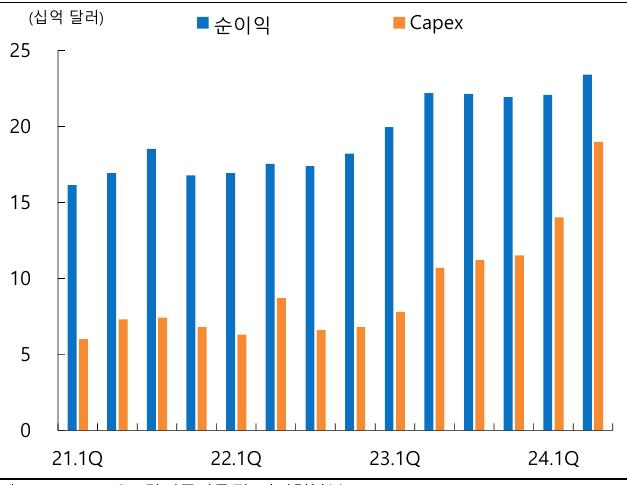

In [85]:
# 첫 번쨰 문서를 이미지로 표시합니다
plt_img_base64(docs[0])

### 검증
왜 이 방법이 효과적인지 이해하기 위해 저장한 이미지를 다시 봅시다.

In [61]:
# 찾아준 이미지와 저정된 이미지의 순서를 확인하여서 이미지 요약 내용이 질문이랑 연관성이 있는지 확인해봅니다.
plt_img_base64(img_base64_list[5])

### Sanity Check

Why does this work? Let's look back at the image that we stored ...


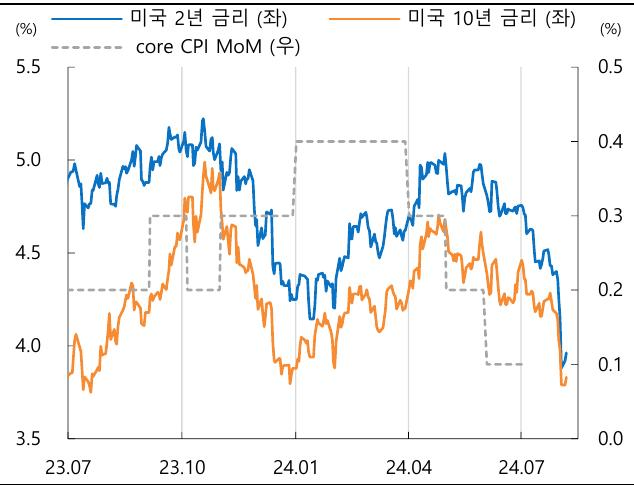

In [63]:
# 해당 이미지의 요약을 확인합니다
image_summaries[5]

In [66]:
image_summaries[5]

' 헤더를 제공하지 않았으므로, 이미지는 일종의 그래프 및 데이터 표시가 있는 것으로 설명될 수 있습니다.\n\n잠에 두 개의 그래프가 있고, 각 그래프는 차트와 데이터 표를 포함하고 있으며, 텍스트가 각 그래프 위에 떨어져 있습니다.\n\n첫 번째 그래프의 제목은 "한국"로, 이는 한국의 시장과 관련된 데이터를 나타내며, 데이터 표는 금융, 신용등의 기업들의 대표적인 정보를 포함하고 있습니다.\n\n두 번째 그래프의 제목은 "한국"로, 이는 한국의 시장과 관련된 데이터를 나타내며, 데이터 표는 기업들의 대표적인 정보를 포함하고 있습니다.\n\n두 개의 그래프에서는 각 그래프에서 "일본"을 찾아볼 수 있으며, 이는 일본과 한국 간의 관련된 정보를 표시합니다.\n\n따라서, 이미지는 전쟁적인 그래프와 데이터 표가 포함되어 있으며, 두 개의 그래프는 "한국"과 "일본"을 중심으로 다룹니다. '

### RAG 실행
질문에 대한 종합적인 답변을 생성하기 위해 RAG를 실행합니다.

In [67]:
# RAG 체인 실행
query = "코스피 관련해서 전망을 종합적으로 알려줘"
chain_multimodal_rag.invoke(query)

' 고객님께 안녕하세요! 코스피와 관련된 전망을 종합적으로 알려드리겠습니다.\n\n일단, 코스피는 한국에서 주식시장의 대표적인 대형 기술제품과 금속 등의 산업의 주요 투자 대상으로 간주됩니다. 일반적인 전망은 국내 경제 성장, 전력 및 유전자 시장 성장 등에 따라 발생할 수 있습니다.\n\n그러나, 코스피는 매우 귀중한 투자 대상이기 때문에 항상 신뢰도와 주당지분을 고려하는 것이 좋습니다. 또한, 전력 및 유전자 시장 등의 산업과 관련된 기업들은 일반적인 경제 성장에도 별도로 영향을 받는 경우가 있습니다.\n\n따라서, 코스피와 관련된 투자에 대해서는 국내 경제 및 기업 성과 등에 따라 변화하며, 전력 및 유전자 시장 등의 산업에도 영향을 받는다는 점을 명심하고, 신뢰도와 주당지분을 귀중히 고려한 것이 좋습니다.\n\n최종적으로, 코스피와 관련된 투자에 대해서는 국내 경제 및 기업 성과 등에 따라 변화할 수 있으므로, 신뢰도와 주당지분을 귀중히 고려하고 유연한 투자 전략을 세우십시오.\n\n저는 이 정보를 바탕으로 긍정적인 투자 조언을 제공할 수 있습니다. 코스피와 관련된 투자에 대해서는 신뢰도와 주당지분을 귀중히 고려하며, 국내 경제 및 기업 성과 등에 따라 변화할 수 있으므로, 유연한 투자 전략을 세우십시오.\n\n감사합니다! '

In [29]:
# 최종 멀티모달 RAG 체인 실행
final_multimodal_rag.invoke(query)

'Here is the translation:\n\n**안녕하세요. 제가 이해한 내용은 아래와 같습니다:**\n\n**KOSPI 지수는 첫 단계로 크게 조정받았지만 미국 증시는 연동의 긴급 조치를 기다리기는 아직 조정이 크지 않다고 판단합니다.**\n\n**11월에는 미국의 대선과 FOMC라는 대규모 이벤트가 있으며 높아진 변동성을 기울이고, 올해 KOSPI 지수는 단기 반적 후 기간조정을 거치다가 11월 미국의 대선과 FOMC를 앞두고 회복세를 보일 것으로 전망하며, 내년 KOSPI 지수의 3,000pt 도전 가능성은 이후의 글로벌 경기 방향성과 미국의 금리인하 속도에 달려 있다고 판단합니다.**\n\n**그림13에서는 선행 P/E(예측 가격-수익률)가 8배까지 급락하며, 20년 코로나 발생과 2018년의 미중 무역분쟁 및 금리인상 텐트럼과 같은 레벨입니다.**\n\n**KOSPI 지수는 11월 초에는 미 대선, FOMC라는 긴급 이벤트가 있으며 높아진 변동성을 기울이고, 올해 KOSPI 지수는 단기 반적 후 기간조정을 거치다가 11월 미국의 대선과 FOMC를 앞두고 회복세를 보일 것으로 전망하며, 내년 KOSPI 지수의 3,000pt 도전 가능성은 이후의 글로벌 경기 방향성과 미국의 금리인하 속도에 달려 있다고 판단합니다.**\n\n**그림14에서는 KOSPI 지수는 단기 반적을 거친 후 기간조정을 거치다가 11월 미국의 대선과 FOMC를 앞두고 회복세를 보일 것으로 전망하며, 내년 KOSPI 지수의 3,000pt 도전 가능성은 이후의 글로벌 경기 방향성과 미국의 금리인하 속도에 달려 있다고 판단합니다.**\n\n**자료 출처: Quantiwise, 하이투자증권 리서치본부**\n\n**제가 알려드릴 점은 11월 미국의 대선과 FOMC라는 큰 이벤트가 있으며 그 후에 KOSPI 지수는 단기 반적을 거친다고 예상합니다.**'

### 고려 사항

**조회**

- 조회는 이미지 요약 및 텍스트 조각과의 유사성을 기반으로 수행됩니다.
- 텍스트 조각이 많을 경우 이미지 조회가 실패할 수 있습니다.
- 이를 방지하기 위해 4k 토큰 크기의 텍스트 조각을 생성하고 이를 요약하여 조회에 사용합니다.

**이미지 크기**

- 답변의 품질은 이미지 크기에 민감합니다. [참고: OpenAI Vision 가이드](https://platform.openai.com/docs/guides/vision).
- 이를 더 면밀히 테스트하기 위해 평가를 수행할 예정입니다.